In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

!pip install pyswarms
import numpy as np
import pyswarms as ps

In [7]:
method =' Quasi-Random Sequence'
prompt = f"generate precisely 100 numbers between -10 to 10 by using {method}, only 2 decimal places, "
prompt_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: {prompt}

ASSISTANT:
'''

response=lcpp_llm(prompt=prompt_template, max_tokens=256, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

import re
import numpy as np

text_response = response['choices'][0]['text']

# Use a regular expression to find all numbers in the response
numbers = re.findall(r'-?\d+\.\d+', text_response)

# Convert the numbers to floats
numbers = [float(num) for num in numbers]

Quasi_Random_Sequence_Initialisation = numbers
print(Quasi_Random_Sequence_Initialisation)

[-9.87, -6.43, -3.51, -1.22, 0.75, 1.49, 2.27, 2.96, 3.64, 4.32, 5.0]



llama_print_timings:        load time =  1690.17 ms
llama_print_timings:      sample time =   132.56 ms /   128 runs   (    1.04 ms per token,   965.58 tokens per second)
llama_print_timings: prompt eval time =  1690.05 ms /    66 tokens (   25.61 ms per token,    39.05 tokens per second)
llama_print_timings:        eval time = 29593.74 ms /   127 runs   (  233.02 ms per token,     4.29 tokens per second)
llama_print_timings:       total time = 31899.41 ms


In [8]:
def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):

    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax


    particles = []
    nSize = np.size(Quasi_Random_Sequence_Initialisation)
    for i in range(nSize):
        position = np.array([Quasi_Random_Sequence_Initialisation[i]] * nVar)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })
    for _ in range(nPop - nSize):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    print(np.size(particles))

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            # Update Velocity
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']

        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")
        g_values.append(GlobalBest['Cost'])
        w *= wdamp

        w_values.append(w)
        g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

# def sphere(x):
#     return sum(x**2)

# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

In [9]:
costs = []
errors = []

def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [11]:
# Run for all 24 problems
folder_path = '/kaggle/input/data-gnbg/'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()

/tmp/ipykernel_30/830117235.py:159: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
/tmp/ipykernel_30/830117235.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


100
Iteration 1: Best Cost = 50744.0143427923
Iteration 2: Best Cost = 37348.38822603057
Iteration 3: Best Cost = 37348.38822603057
Iteration 4: Best Cost = 32651.518237873614
Iteration 5: Best Cost = 23518.212655146446
Iteration 6: Best Cost = 18788.581719316808
Iteration 7: Best Cost = 14384.390993654217
Iteration 8: Best Cost = 13980.433800614008
Iteration 9: Best Cost = 10679.386125300884
Iteration 10: Best Cost = 6214.8020396125885
Iteration 11: Best Cost = 5123.839691639441
Iteration 12: Best Cost = 4192.5537722787485
Iteration 13: Best Cost = 3379.2831208022026
Iteration 14: Best Cost = 3044.8921957526063
Iteration 15: Best Cost = 1689.4821121941716
Iteration 16: Best Cost = 1529.7747667214546
Iteration 17: Best Cost = 582.2416260240734
Iteration 18: Best Cost = 457.7513885563808
Iteration 19: Best Cost = 457.7513885563808
Iteration 20: Best Cost = 393.11266942337147
Iteration 21: Best Cost = 251.1383859062962
Iteration 22: Best Cost = -143.76298923990566
Iteration 23: Best Cost

In [12]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

5.3432813729159534e-11
0.2714014895851733
1.7679650056834362e-05
8.799077022558777e-09
1.0614752559189924
1.2713169989393407
23622.951712977952
0.001339510184379833
1100.4290764289503
9768.285738387633
19725.88557789965
4054.594468569321
1159.0573154552906
14636.833429267337
6.200653842746817
580.1000000003669
682.1001313830384
6692.903848095792
17212.3282044112
10.55364099706857
6.044942478658811
69444.0034072391
38.300188343704576
138.6167865851488





Problem 1 Best Cost: [50744.01434279 37348.38822603 37348.38822603 32651.51823787
 23518.21265515 18788.58171932 14384.39099365 13980.43380061
 10679.3861253   6214.80203961  5123.83969164  4192.55377228
  3379.2831208   3044.89219575  1689.48211219  1529.77476672
   582.24162602   457.75138856   457.75138856   393.11266942
   251.13838591  -143.76298924  -143.76298924  -263.80059103
  -431.75262838  -548.86323565  -548.86323565  -548.86323565
  -573.82887198  -676.79256673  -676.79256673  -676.79256673
  -676.79256673  -683.37554453  -683.37554453  -698.89777498
  -709.28123903  -744.19154037  -770.27450006  -770.27450006
  -774.44116943  -828.7703452   -828.7703452   -858.92417776
  -896.61361572  -896.61361572  -896.61361572  -896.61361572
  -905.13669133  -914.339768    -914.339768    -914.339768
  -953.87837032  -953.87837032  -960.72876565  -960.72876565
  -979.46437718 -1004.43309654 -1005.73344662 -1005.73344662
 -1009.4804872  -1009.4804872  -1029.01972734 -1036.123573
 -10

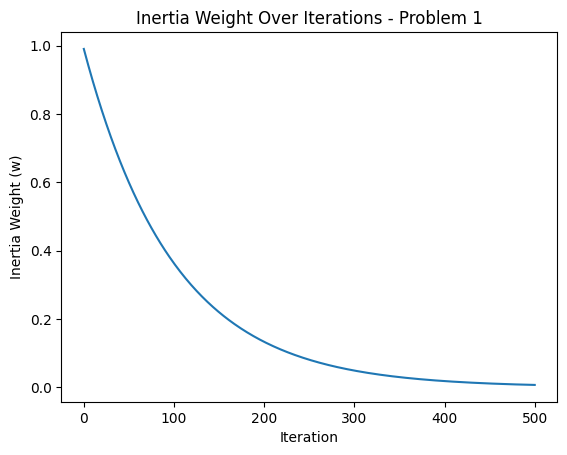

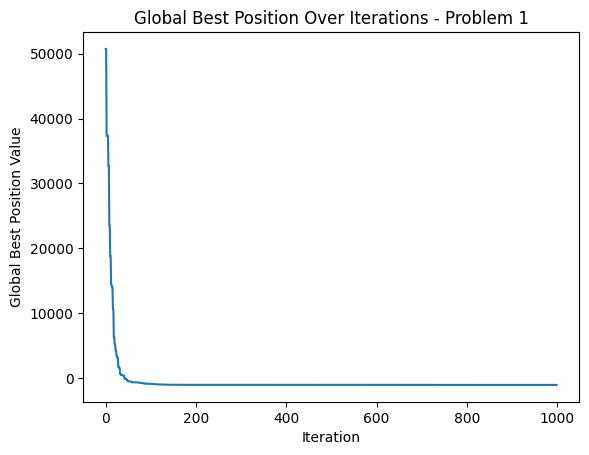




Problem 2 Best Cost: [-701.40379082 -701.41236946 -701.42462212 -701.44034663 -701.46105113
 -701.49661883 -701.50941739 -701.52830876 -701.52830876 -701.57198123
 -701.57947186 -701.58938947 -701.59488706 -701.61210347 -701.65802145
 -701.65802145 -701.65802145 -701.66738124 -701.67451541 -701.68677916
 -701.69350795 -701.69350795 -701.70268024 -701.71967104 -701.73238214
 -701.73678035 -701.74083279 -701.74166522 -701.74855359 -701.74855359
 -701.76270237 -701.76270237 -701.77266054 -701.77809855 -701.77809855
 -701.78887753 -701.78887753 -701.80013926 -701.8096892  -701.81634922
 -701.81634922 -701.81710044 -701.81983243 -701.81983243 -701.83303322
 -701.83303322 -701.83303322 -701.83303322 -701.84756461 -701.8582036
 -701.85966635 -701.85966635 -701.88125131 -701.88125131 -701.88125131
 -701.88125131 -701.89464773 -701.89464773 -701.89464773 -701.90747799
 -701.90866734 -701.93132963 -701.93132963 -701.93598372 -701.93598372
 -701.93598372 -701.94062905 -701.94062905 -701.952036

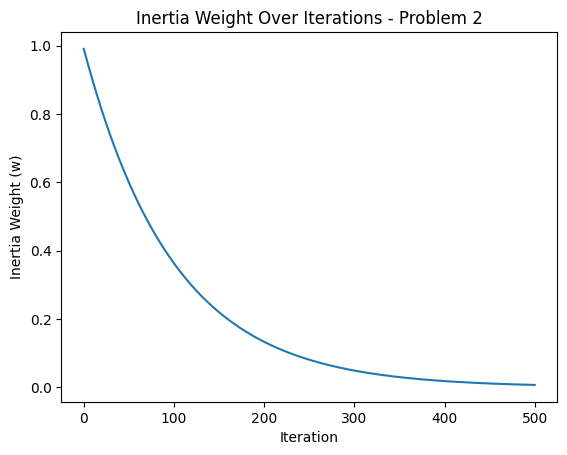

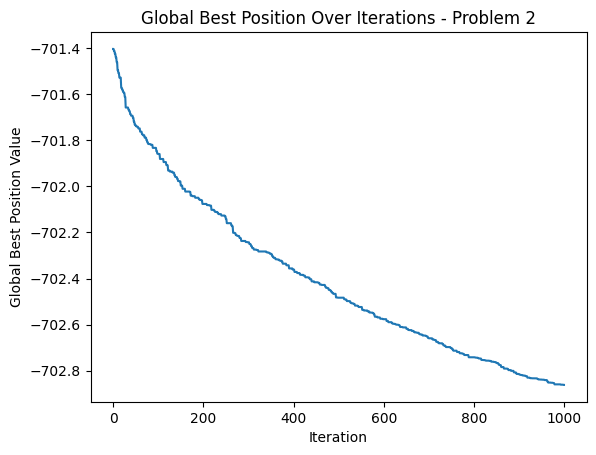




Problem 3 Best Cost: [ 3.69670687e+10  3.05846424e+10  2.27197304e+10  1.92360116e+10
  1.54284063e+10  1.14707790e+10  7.18370418e+09  5.71161804e+09
  5.26411205e+09  4.66961824e+09  3.96508951e+09  3.66908414e+09
  2.83690537e+09  2.41465285e+09  1.95847827e+09  1.87294898e+09
  1.52559123e+09  1.51204110e+09  8.53952081e+08  8.53952081e+08
  7.41713112e+08  7.41713112e+08  6.57045929e+08  6.57045929e+08
  5.41389277e+08  4.52695337e+08  4.18387126e+08  4.18387126e+08
  2.79529716e+08  2.79529716e+08  2.14096738e+08  2.13193704e+08
  1.95429501e+08  1.69852188e+08  1.69852188e+08  1.69852188e+08
  1.69632788e+08  1.09677019e+08  1.00073308e+08  1.00073308e+08
  1.00073308e+08  1.00073308e+08  8.08701455e+07  6.93637183e+07
  6.93637183e+07  6.80513949e+07  5.82292840e+07  5.82292840e+07
  5.58574975e+07  5.26753842e+07  5.26753842e+07  5.26753842e+07
  5.02648429e+07  5.02648429e+07  5.02648429e+07  4.79126603e+07
  4.79126603e+07  3.86244010e+07  3.86244010e+07  3.86244010e+07
 

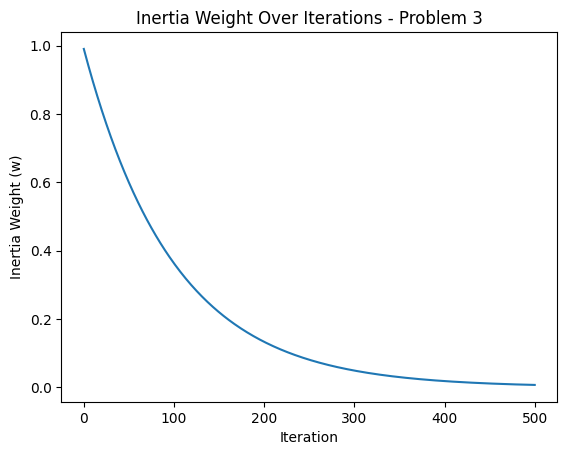

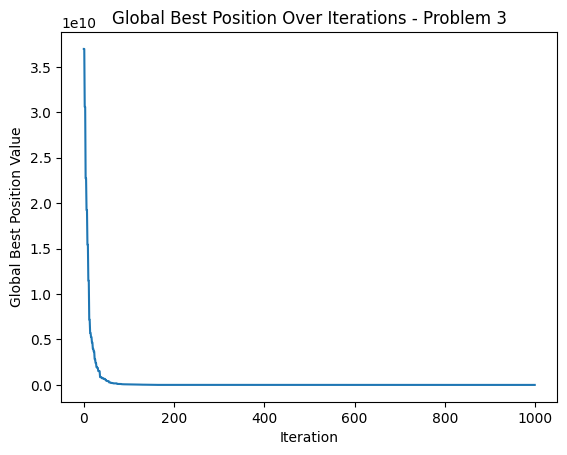




Problem 4 Best Cost: [ 3.10894830e+05  2.50371855e+05  2.31722632e+05  2.04068552e+05
  1.25799013e+05  9.06641126e+04  7.45864549e+04  5.63984319e+04
  5.35805803e+04  4.29426197e+04  3.65520657e+04  2.63525474e+04
  2.56020556e+04  2.05521943e+04  1.77948895e+04  1.47951567e+04
  1.30587014e+04  1.27833131e+04  7.41545357e+03  7.19730183e+03
  6.73664200e+03  5.56621363e+03  4.54597477e+03  4.40600060e+03
  3.39495580e+03  3.08874582e+03  2.51039197e+03  2.51039197e+03
  1.96080946e+03  1.61850491e+03  1.61850491e+03  1.40815866e+03
  1.40815866e+03  9.56086187e+02  6.48101962e+02  6.48101962e+02
  6.07839431e+02  6.07839431e+02  6.07839431e+02  6.07839431e+02
  4.06210718e+02  1.08437763e+02  1.08437763e+02  1.30192193e+01
  1.30192193e+01 -5.87422479e+00 -5.87422479e+00 -5.87422479e+00
 -1.26316372e+01 -1.04715430e+02 -1.04715430e+02 -1.04715430e+02
 -2.05117475e+02 -2.05117475e+02 -2.05117475e+02 -2.05117475e+02
 -2.05117475e+02 -2.05117475e+02 -2.13801220e+02 -2.28456416e+02
 

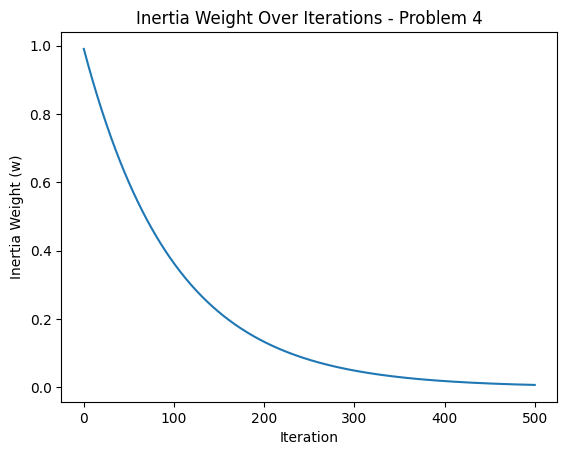

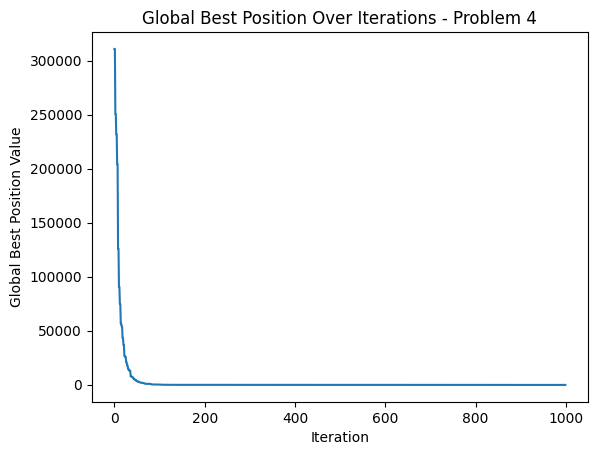




Problem 5 Best Cost: [-334.16502761 -334.21769256 -334.26830904 -334.27651886 -334.30485838
 -334.30485838 -334.31806947 -334.36041791 -334.43858569 -334.48315382
 -334.53821839 -334.55457065 -334.55873017 -334.58767465 -334.59989525
 -334.64925397 -334.67834844 -334.67834844 -334.67834844 -334.71136175
 -334.71136175 -334.72226442 -334.72226442 -334.74830944 -334.78664973
 -334.80795657 -334.81749716 -334.8240245  -334.84919673 -334.84919673
 -334.84919673 -334.86259606 -334.87444278 -334.87444278 -334.89254492
 -334.89254492 -334.89254492 -334.89324184 -334.89324184 -334.89324184
 -334.91060549 -334.96110204 -334.96110204 -334.96110204 -334.96110204
 -334.96110204 -334.96839779 -334.97687021 -334.99422932 -334.99941379
 -335.00885244 -335.01576697 -335.05082171 -335.06552013 -335.07161306
 -335.07596603 -335.09358174 -335.09358174 -335.09358174 -335.09358174
 -335.09358174 -335.09358174 -335.11062692 -335.13529584 -335.13529584
 -335.13802302 -335.15974395 -335.15974395 -335.15974

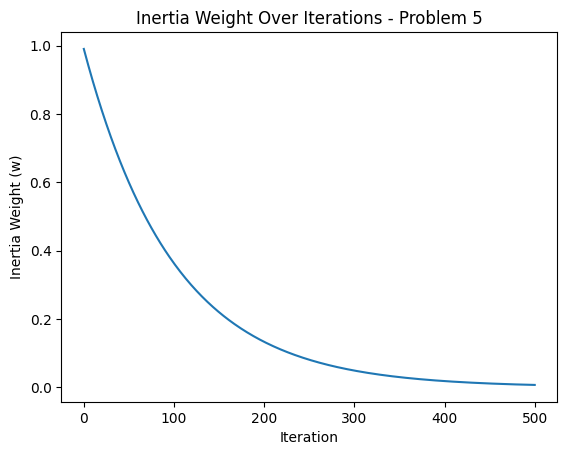

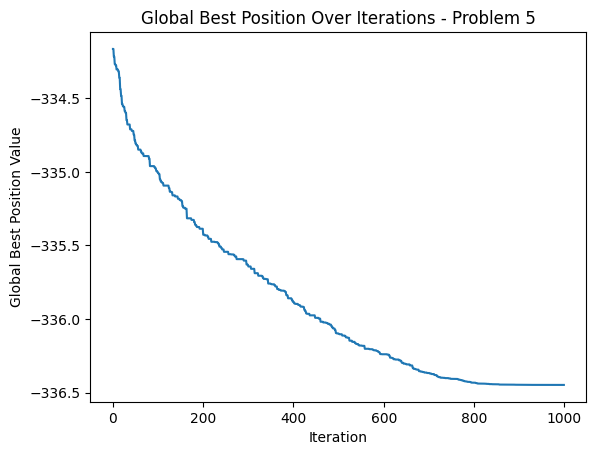




Problem 6 Best Cost: [-183.51934546 -183.57140481 -183.61301968 -183.65030393 -183.71183727
 -183.79289535 -183.84055213 -183.8591263  -183.87211937 -183.87612418
 -183.91954308 -183.99931618 -183.99931618 -184.04687539 -184.06139642
 -184.0985471  -184.11045409 -184.11045409 -184.11045409 -184.1464787
 -184.1464787  -184.1464787  -184.16805579 -184.17027635 -184.19350446
 -184.20042781 -184.20196865 -184.20196865 -184.22307224 -184.22307224
 -184.22307224 -184.23734328 -184.25548766 -184.26261435 -184.26261435
 -184.26861674 -184.27220214 -184.27220214 -184.27859406 -184.27859406
 -184.27859406 -184.27859406 -184.31352352 -184.31352352 -184.31352352
 -184.32001379 -184.32001379 -184.32031609 -184.32894245 -184.35388716
 -184.35388716 -184.35388716 -184.35732714 -184.35732714 -184.37235774
 -184.38124493 -184.38124493 -184.38752282 -184.40472595 -184.40878303
 -184.40878303 -184.41202577 -184.42486855 -184.42486855 -184.43264487
 -184.43264487 -184.46260422 -184.46260422 -184.468046

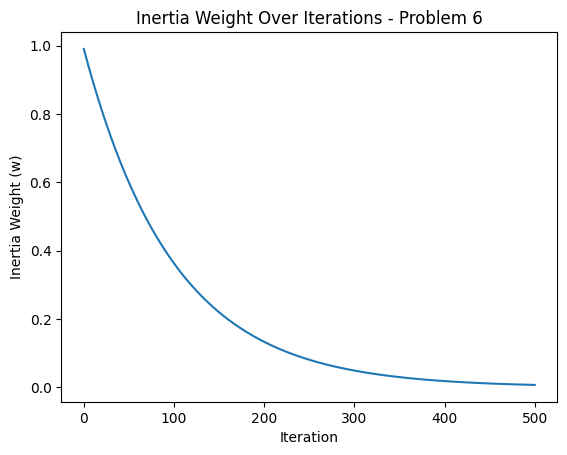

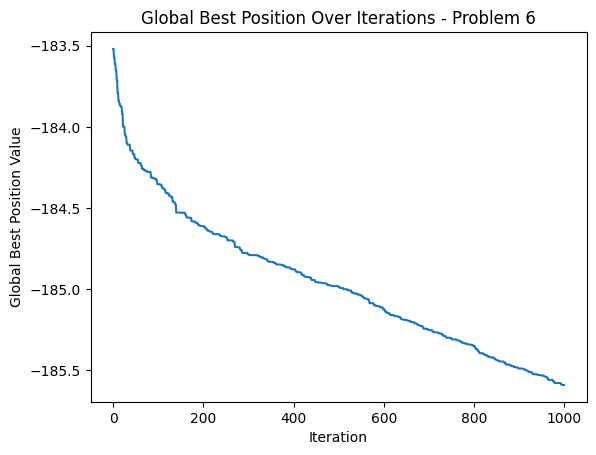




Problem 7 Best Cost: [57419.18953083 53477.97284915 52896.0437916  51483.67669345
 51483.67669345 46619.77141038 46619.77141038 46619.77141038
 45352.42270344 45352.42270344 45352.42270344 42281.82950261
 42281.82950261 40177.34344848 40177.34344848 38355.37632307
 38355.37632307 38088.19376183 37134.24082919 37134.24082919
 37087.20237753 36510.94376235 36103.81097327 36103.81097327
 36103.81097327 35721.44574963 35721.44574963 35684.96357079
 35570.3817463  34884.77264656 34884.77264656 33283.35726279
 32388.934086   32388.934086   32388.934086   31606.0600932
 31606.0600932  31606.0600932  31606.0600932  31606.0600932
 31606.0600932  31606.0600932  31606.0600932  31233.16049801
 31233.16049801 31233.16049801 31233.16049801 31074.6298687
 30440.70703167 30440.70703167 30186.59559222 30139.42063002
 30070.29699393 29568.37727159 29568.37727159 29568.37727159
 29568.37727159 29568.37727159 29568.37727159 29568.37727159
 29568.37727159 28850.49648323 28850.49648323 28779.59274301
 28

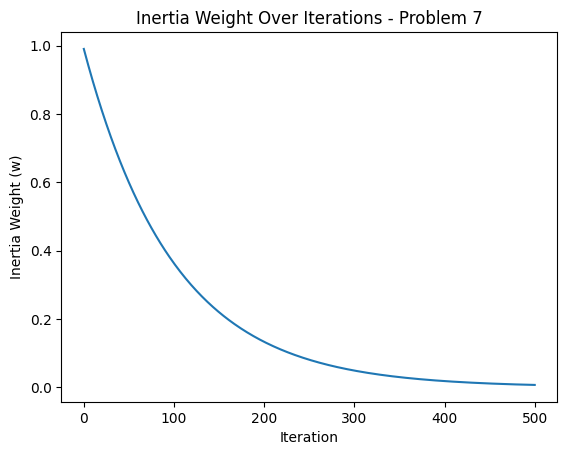

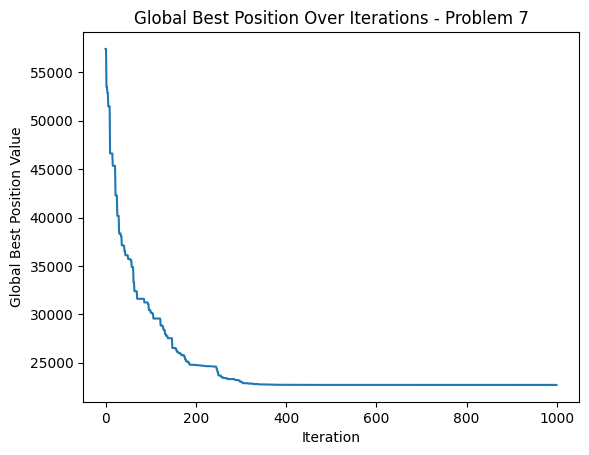




Problem 8 Best Cost: [55725.46770003 49856.46237982 30469.59503507 30469.59503507
 23156.26571048 15110.2589304  15110.2589304  13220.88709218
 12431.87113401 10690.67182987 10690.67182987 10436.48112131
 10436.48112131 10022.01320169  7646.54161331  6808.23721007
  6808.23721007  6808.23721007  5838.89146183  5528.60630673
  5345.40928419  5345.40928419  4839.98605532  4535.96900436
  4535.96900436  4535.96900436  3550.00919305  3082.29462137
  3082.29462137  2669.09669596  1917.57067598  1917.57067598
  1917.57067598  1917.57067598  1891.59059395   659.18642465
   659.18642465   575.63495576   531.28524846   531.28524846
   278.91636988   233.9578622    233.9578622    167.28196083
   167.28196083   111.43468282  -171.73278715  -171.73278715
  -171.73278715  -225.27447872  -225.27447872  -238.16615593
  -337.91244741  -337.91244741  -337.91244741  -362.548536
  -362.548536    -382.65954754  -382.65954754  -498.97613386
  -498.97613386  -498.97613386  -498.97613386  -498.97613386
  

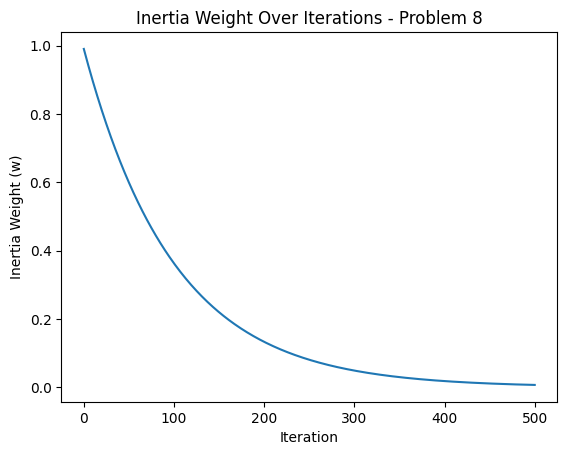

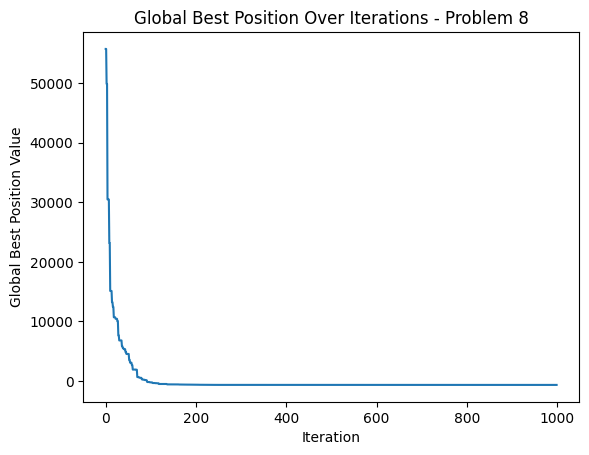




Problem 9 Best Cost: [173921.91876746 102121.82362111 102121.82362111 102121.82362111
 102121.82362111 102121.82362111 102121.82362111 101853.91852346
  75136.43899497  75136.43899497  75136.43899497  71753.87937826
  71753.87937826  54808.95540747  54808.95540747  54808.95540747
  38661.16968257  38661.16968257  38661.16968257  38661.16968257
  38661.16968257  38661.16968257  32030.94463483  32030.94463483
  32030.94463483  32030.94463483  15509.52669422  15509.52669422
  15509.52669422  15509.52669422  15509.52669422  15509.52669422
  15509.52669422  15509.52669422  15509.52669422  15509.52669422
  15509.52669422  15509.52669422   3433.33106816   3433.33106816
   3433.33106816   3433.33106816   3433.33106816   3433.33106816
   3433.33106816   3433.33106816   3433.33106816   3433.33106816
   3433.33106816   3433.33106816   3433.33106816   3433.33106816
   3433.33106816   3323.1905321    3323.1905321    3192.99344609
   3192.99344609   3153.64103264   3153.64103264   2396.0620105
  

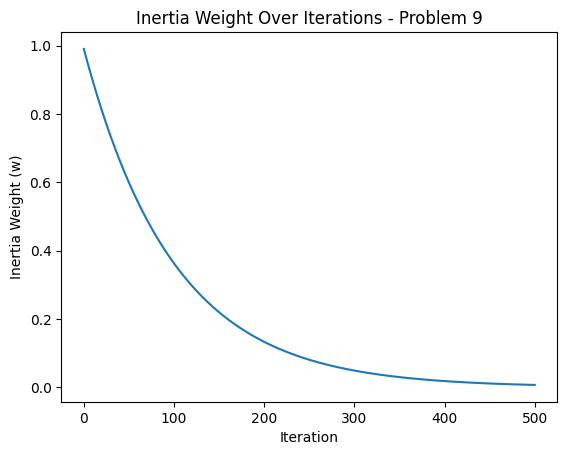

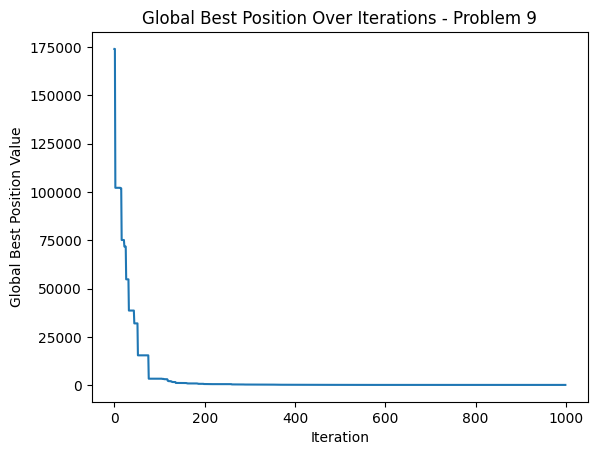




Problem 10 Best Cost: [36363.26475236 36363.26475236 36363.26475236 34723.56503541
 34723.56503541 31435.51937798 31435.51937798 17000.09923485
 17000.09923485 17000.09923485 17000.09923485 17000.09923485
 17000.09923485 17000.09923485 17000.09923485 17000.09923485
 16491.70826461 14511.68554409 14511.68554409 14511.68554409
 14511.68554409 14511.68554409 14511.68554409 14511.68554409
 14511.68554409 13956.66522796 13956.66522796 13956.66522796
 13452.99296366 13452.99296366 13452.99296366 13298.25637628
 12976.05612091 12976.05612091 12897.58908876 12885.89440148
 12569.37392601 12569.37392601 12569.37392601 11315.57440063
 11315.57440063 11315.57440063 11315.57440063 11315.57440063
 11315.57440063 11137.5218018  11010.21791303 11010.21791303
 11010.21791303 11010.21791303 10923.35215093 10923.35215093
 10923.35215093 10923.35215093 10916.01118511 10399.78221435
 10399.78221435 10399.78221435 10399.78221435 10399.78221435
 10344.63876651 10344.63876651 10344.63876651 10327.30922399

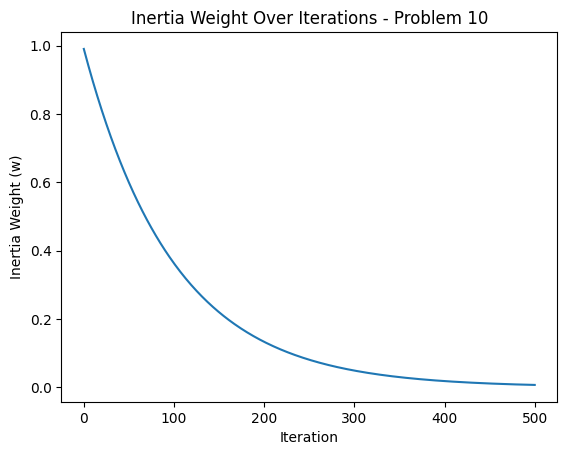

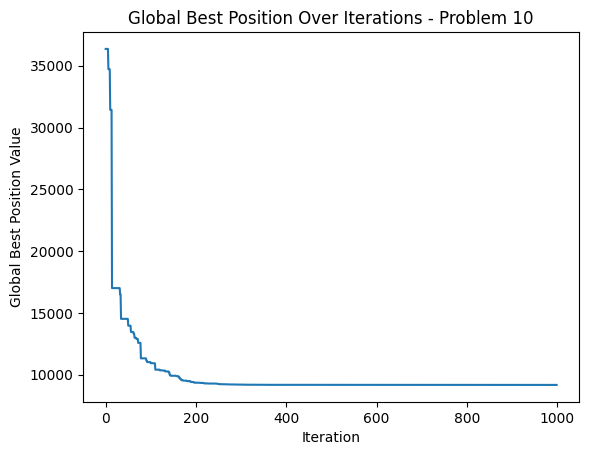




Problem 11 Best Cost: [58347.45966022 48911.38248873 48911.38248873 48911.38248873
 48911.38248873 43146.45225781 43146.45225781 43146.45225781
 40069.68674201 36017.64642206 34917.7942291  33617.04326081
 33617.04326081 33617.04326081 33617.04326081 33617.04326081
 33617.04326081 33617.04326081 33617.04326081 33617.04326081
 30845.86326654 30845.86326654 30845.86326654 30845.86326654
 29625.04281456 29074.98254415 29074.98254415 29074.98254415
 29074.98254415 29074.98254415 28273.23200325 26619.51167271
 26619.51167271 26619.51167271 26619.51167271 26619.51167271
 25416.20441259 25416.20441259 25416.20441259 25416.20441259
 25416.20441259 25272.50144805 25272.50144805 25272.50144805
 25272.50144805 25272.50144805 24069.2109599  24069.2109599
 24069.2109599  24069.2109599  24069.2109599  23475.68415147
 23475.68415147 23475.68415147 23475.68415147 22843.01564122
 22843.01564122 22843.01564122 22843.01564122 22843.01564122
 22843.01564122 22843.01564122 22843.01564122 22843.01564122


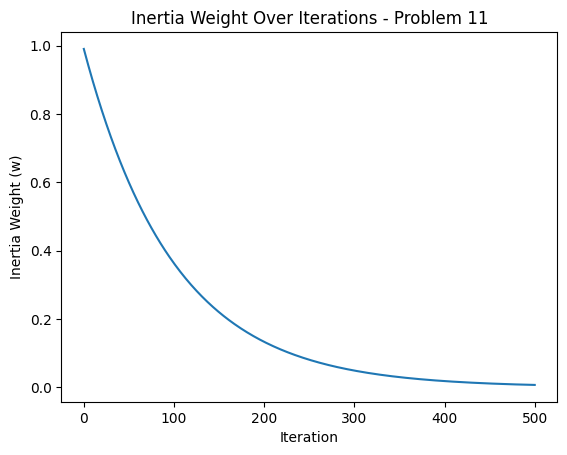

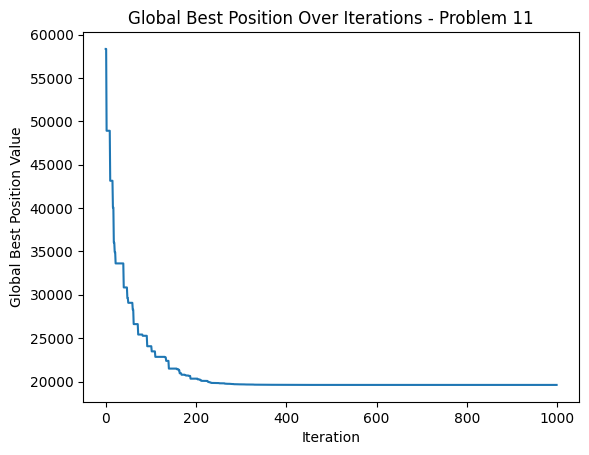




Problem 12 Best Cost: [64011.45413261 47539.74792089 45165.77506233 22969.93141782
 22969.93141782 21021.44795533 20044.97206996 15544.17546819
 14279.50306901 14279.50306901 11241.83002163 11178.45612324
 11178.45612324 10978.48799348 10866.59784941 10866.59784941
  8381.59296693  8381.59296693  8381.59296693  8381.59296693
  8381.59296693  8316.39579473  8316.39579473  8316.39579473
  7429.47676353  6065.362727    6065.362727    6065.362727
  6065.362727    6065.362727    6065.362727    6065.362727
  6065.362727    6065.362727    6065.362727    6065.362727
  6065.362727    6065.362727    6065.362727    6065.362727
  6065.362727    6065.362727    6065.362727    6065.362727
  6065.362727    6065.362727    6065.362727    5248.79627244
  5248.79627244  5248.79627244  5248.79627244  5248.79627244
  5248.79627244  5248.79627244  5248.79627244  5144.52307446
  5144.52307446  5144.52307446  5144.52307446  5144.52307446
  5144.52307446  5144.52307446  4923.20842098  4923.20842098
  4923.20

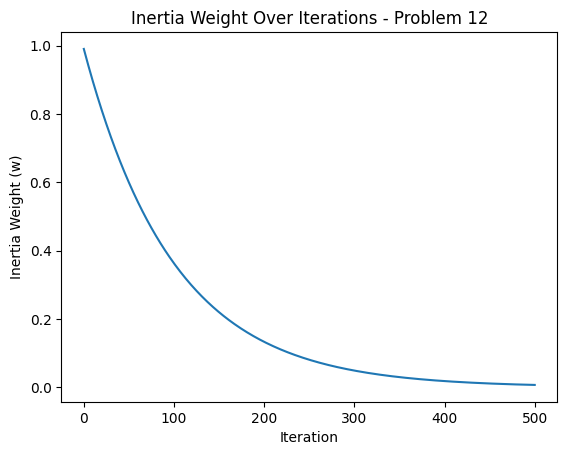

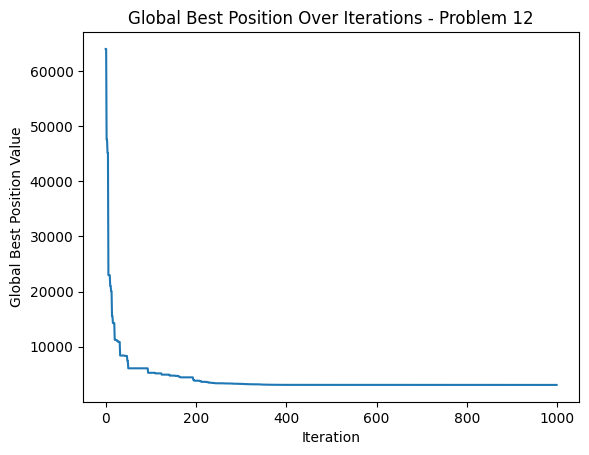




Problem 13 Best Cost: [270022.4388504  140273.50028546 140273.50028546 121410.56238992
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17824.17086322  17824.17086322  17824.17086322  17824.17086322
  17705.60875882  17705.60875882  17705.60875882  17705.60875882
  17705.60875882  17705.60875882  17705.60875882  17705.60875882
  17705.60875882  17705.60875882  17705.60875882  17705.60875882
  17705.60875882  17705.60875882  17705.60875882  17705.60875882
  17705.60875882  17705.60875882  13075.4196225   13075.4196225
 

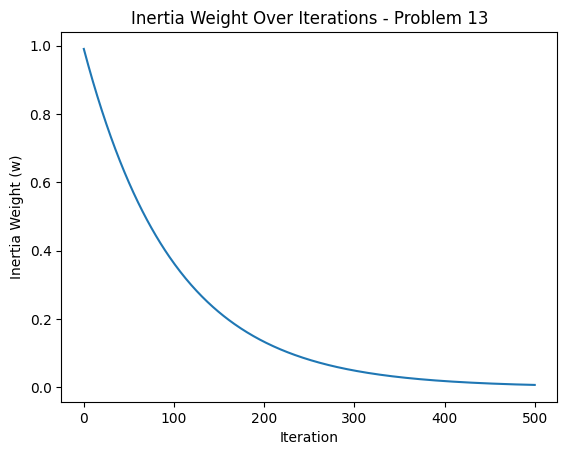

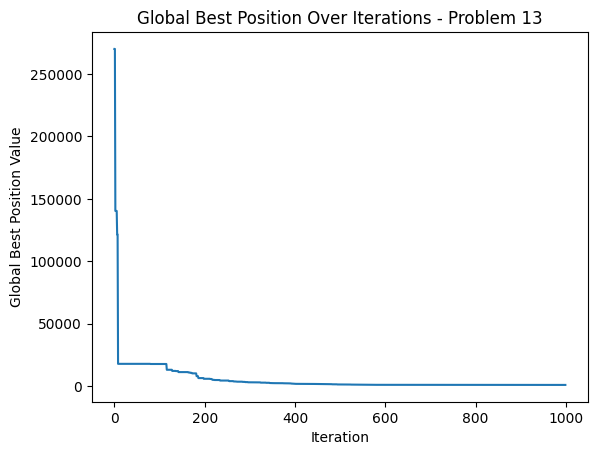




Problem 14 Best Cost: [23770.06444393 23770.06444393 22802.31962453 22802.31962453
 21284.86714946 21284.86714946 20917.18526749 20917.18526749
 20739.21080319 20739.21080319 19955.22811018 19955.22811018
 19955.22811018 19955.22811018 19955.22811018 19955.22811018
 19955.22811018 19955.22811018 19955.22811018 19955.22811018
 19955.22811018 19955.22811018 19955.22811018 19955.22811018
 19955.22811018 19955.22811018 19545.81871112 19545.81871112
 19545.81871112 18619.48465809 18619.48465809 18619.48465809
 18619.48465809 18619.48465809 18619.48465809 18619.48465809
 18619.48465809 18619.48465809 18619.48465809 18619.48465809
 18619.48465809 18619.48465809 18619.48465809 18619.48465809
 18619.48465809 18619.48465809 18619.48465809 18365.94083851
 18365.94083851 18365.94083851 18365.94083851 18365.94083851
 18231.01291672 18231.01291672 18231.01291672 18231.01291672
 18231.01291672 18231.01291672 17555.29250826 17555.29250826
 17555.29250826 17555.29250826 17260.89763715 17260.89763715

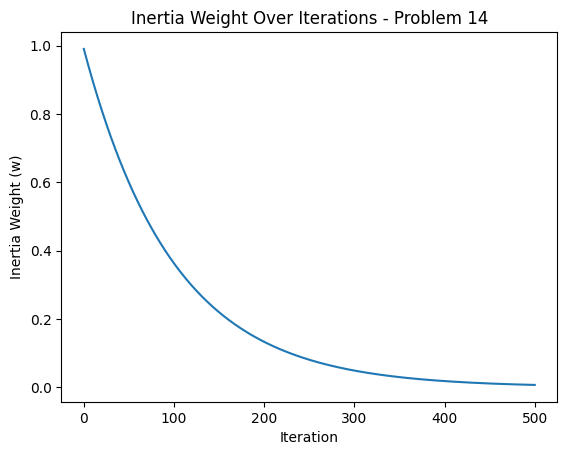

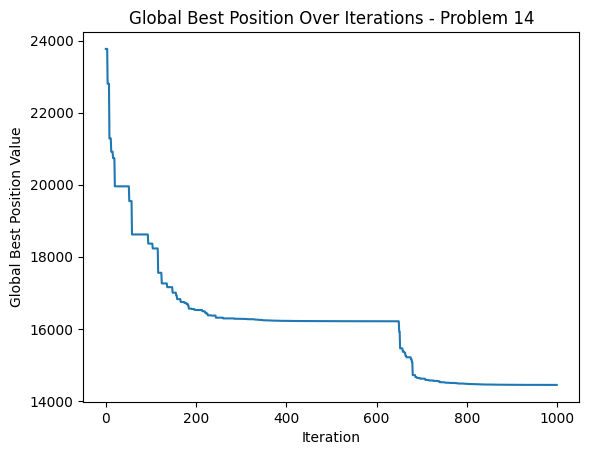




Problem 15 Best Cost: [-224.76531136 -224.76531136 -224.97823892 -224.97823892 -225.02142665
 -225.02142665 -225.62341929 -225.84450455 -225.84450455 -225.84450455
 -226.04314692 -226.04314692 -226.04314692 -226.37214569 -226.68512455
 -226.68512455 -226.68512455 -226.68512455 -226.89289001 -226.89289001
 -226.89289001 -226.89289001 -226.94028664 -226.94028664 -226.94028664
 -226.94028664 -226.94028664 -226.94028664 -226.94028664 -226.94028664
 -227.17362752 -227.17362752 -227.66598127 -227.66598127 -227.66598127
 -227.66598127 -227.66598127 -227.66598127 -227.66598127 -227.66598127
 -227.66598127 -227.66598127 -227.71587527 -227.71587527 -227.71587527
 -227.79289634 -227.79289634 -227.79289634 -227.82931646 -227.82931646
 -227.82931646 -227.82931646 -227.82931646 -227.82931646 -227.82931646
 -227.82931646 -227.83193316 -227.84769946 -227.84769946 -227.92307825
 -227.92307825 -227.9760708  -227.9760708  -227.9760708  -227.9760708
 -227.9760708  -227.9760708  -227.98464577 -227.99330

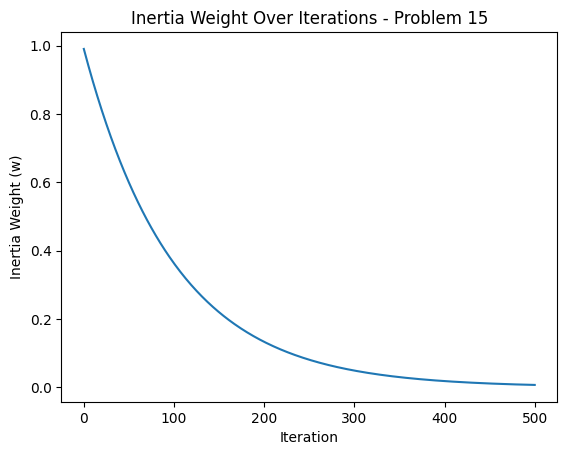

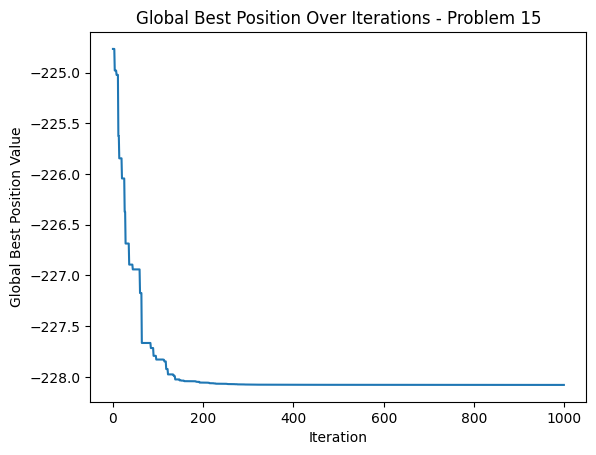




Problem 16 Best Cost: [41899.15043838 39060.64391545 32130.50375316 29406.68669039
 22781.84804017 12465.24132796 10315.13084557  5687.70029162
  5278.3290142   2379.81972357   892.62277843  -763.75825726
 -1443.86176729 -1443.86176729 -1933.53192659 -2511.37353337
 -2987.42578062 -2987.42578062 -2987.42578062 -2987.42578062
 -3220.28185119 -3335.59947374 -3507.44828456 -3660.69232375
 -3757.03518957 -3806.92523493 -3858.43161673 -3972.91070529
 -4122.67155913 -4122.67155913 -4122.67155913 -4122.67155913
 -4122.67155913 -4177.53106503 -4177.53106503 -4200.6725422
 -4210.61413391 -4210.61413391 -4210.61413391 -4213.977239
 -4215.86909533 -4230.61537801 -4230.61537801 -4256.0414996
 -4256.0414996  -4256.0414996  -4290.83713223 -4294.78839637
 -4303.08596209 -4303.08596209 -4303.08596209 -4311.63109523
 -4330.0177506  -4340.73384634 -4350.71285827 -4350.71285827
 -4350.71285827 -4350.71285827 -4350.71285827 -4350.71285827
 -4368.70950124 -4368.70950124 -4376.68458663 -4392.09531985
 -4

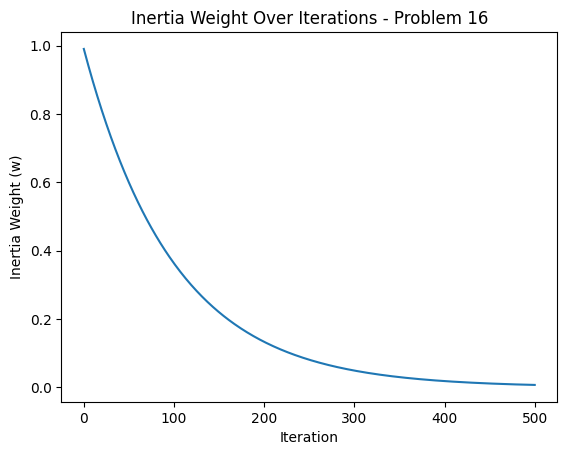

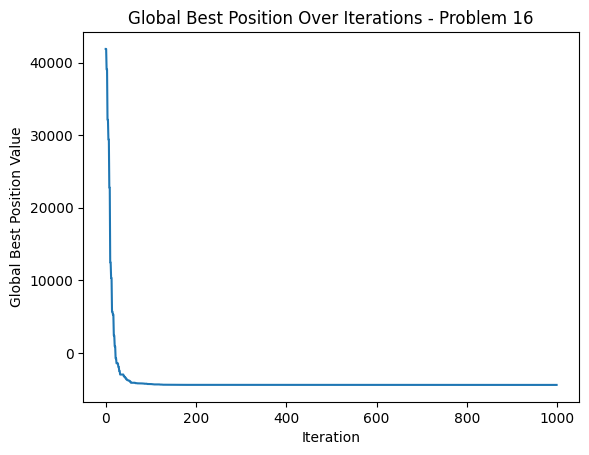




Problem 17 Best Cost: [ 3.10747514e+06  2.38445895e+06  1.72752978e+06  1.48273222e+06
  1.16229778e+06  8.70193357e+05  6.18923219e+05  5.60712920e+05
  3.97679552e+05  3.89970194e+05  3.28290992e+05  2.20712762e+05
  1.37819412e+05  1.09246023e+05  9.07526033e+04  7.35148986e+04
  7.35148986e+04  5.83077502e+04  5.83077502e+04  4.49520933e+04
  4.49520933e+04  3.97825325e+04  3.97825325e+04  3.53509849e+04
  2.79093362e+04  2.79093362e+04  2.79093362e+04  2.79093362e+04
  2.21451740e+04  1.71192620e+04  1.62205939e+04  1.28406593e+04
  1.28406593e+04  1.28406593e+04  1.28406593e+04  1.03810454e+04
  1.03810454e+04  1.03810454e+04  6.53391340e+03  6.53391340e+03
  4.92027961e+03  4.92027961e+03  4.70316146e+03  3.92646478e+03
  3.82005966e+03  3.82005966e+03  2.82334822e+03  2.40484357e+03
  2.40484357e+03  2.40484357e+03  2.15534724e+03  1.52983930e+03
  9.34280311e+02  4.63992162e+02  4.63992162e+02  4.63992162e+02
  4.63992162e+02  9.01131236e+01  9.01131236e+01  9.01131236e+01


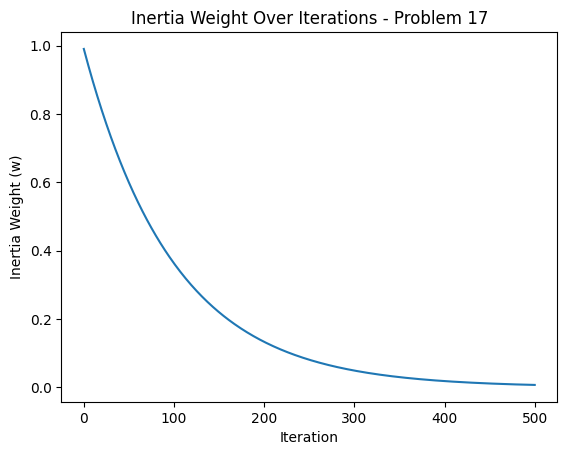

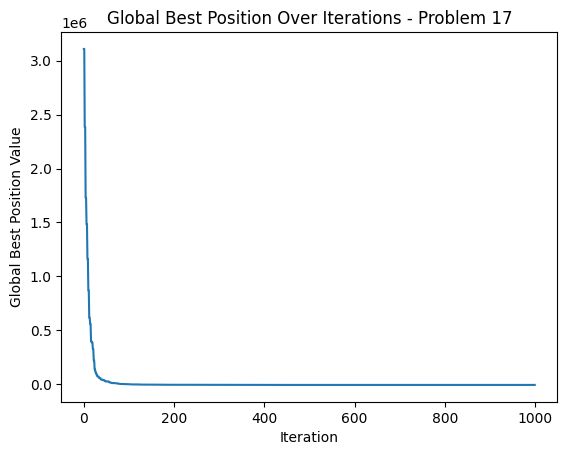




Problem 18 Best Cost: [44301.17654602 36665.21684298 36665.21684298 36665.21684298
 36665.21684298 31245.21499082 31245.21499082 28732.31619863
 28732.31619863 28590.41853146 27588.97289957 25910.4880097
 25910.4880097  24791.19825591 23423.28521554 20695.22157389
 20695.22157389 18368.45251685 18368.45251685 18132.36798417
 18132.36798417 18132.36798417 14363.09195855 13627.85068925
 13627.85068925 13627.85068925 13627.85068925 13627.85068925
 12850.38251062 10696.93240585 10696.93240585  9081.677285
  9081.677285    9081.677285    9081.677285    9081.677285
  9081.677285    8482.21664046  8221.20659949  8221.20659949
  8199.09423907  8199.09423907  8199.09423907  8199.09423907
  8199.09423907  7174.85648097  7174.85648097  6063.04728446
  6063.04728446  6063.04728446  6063.04728446  6063.04728446
  6063.04728446  6063.04728446  4773.14259721  4773.14259721
  4773.14259721  4479.59865177  4479.59865177  4243.39984191
  4243.39984191  4243.39984191  4243.39984191  4243.39984191
  42

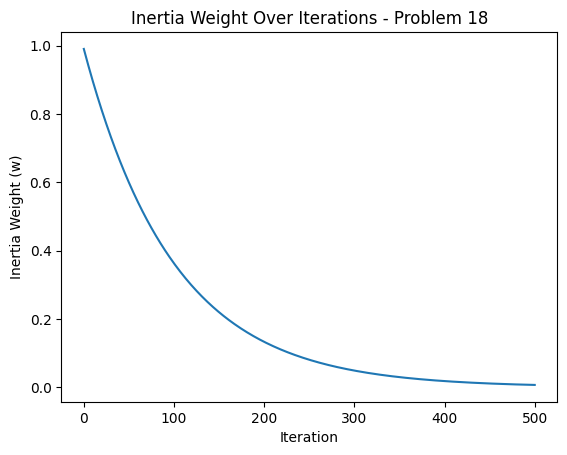

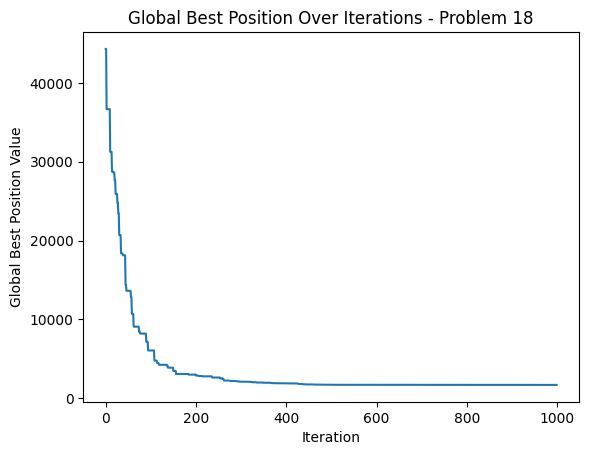




Problem 19 Best Cost: [43982.89238351 37870.66803884 37870.66803884 37870.66803884
 37870.66803884 37870.66803884 37870.66803884 37870.66803884
 37870.66803884 37870.66803884 37870.66803884 37870.66803884
 37870.66803884 37870.66803884 37870.66803884 37870.66803884
 37870.66803884 37870.66803884 37870.66803884 37870.66803884
 33231.88766337 33231.88766337 33231.88766337 33231.88766337
 33231.88766337 33231.88766337 33231.88766337 33231.88766337
 33231.88766337 33231.88766337 33231.88766337 33231.88766337
 28513.29221728 28513.29221728 28513.29221728 28513.29221728
 28513.29221728 28513.29221728 28513.29221728 28513.29221728
 28513.29221728 28513.29221728 28513.29221728 28513.29221728
 28513.29221728 28513.29221728 28513.29221728 28513.29221728
 28513.29221728 28513.29221728 28004.61875763 28004.61875763
 28004.61875763 28004.61875763 28004.61875763 28004.61875763
 28004.61875763 28004.61875763 28004.61875763 25523.59764005
 25523.59764005 25523.59764005 25523.59764005 25523.59764005

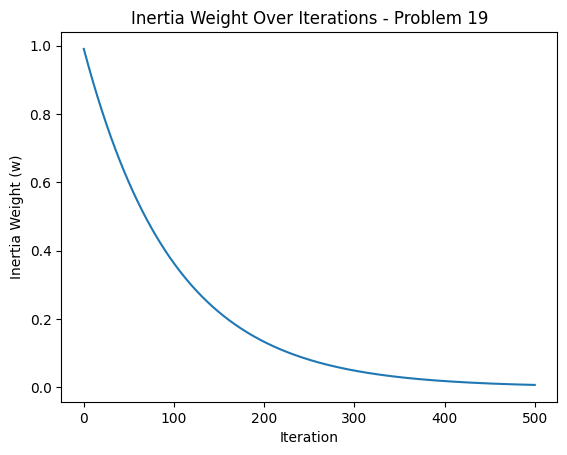

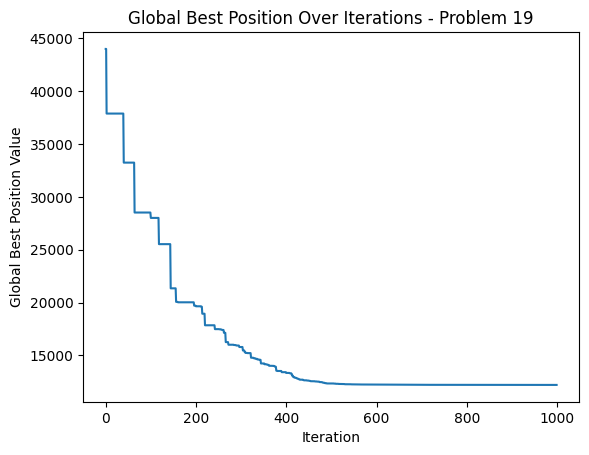




Problem 20 Best Cost: [-83.64463593 -84.1549827  -84.21132816 -84.21132816 -84.99257143
 -84.99257143 -85.35264658 -85.35264658 -85.35264658 -85.53894092
 -85.53894092 -85.53894092 -85.53894092 -85.53894092 -85.95302492
 -85.95302492 -85.95302492 -85.95302492 -86.20519333 -86.20519333
 -86.60431275 -86.60875041 -86.60875041 -86.60875041 -86.60875041
 -86.60875041 -86.60875041 -86.89042834 -86.89042834 -86.9375392
 -87.20812143 -87.33961012 -87.72299146 -87.72299146 -87.72299146
 -87.72299146 -87.72299146 -87.72299146 -87.72299146 -87.72299146
 -87.72299146 -87.72299146 -87.72299146 -87.85170271 -87.85170271
 -87.85170271 -87.85170271 -87.85170271 -87.96690626 -87.96690626
 -87.96690626 -87.96690626 -87.96690626 -88.09108486 -88.09108486
 -88.09108486 -88.09108486 -88.09108486 -88.09108486 -88.09108486
 -88.11843404 -88.11843404 -88.11843404 -88.11843404 -88.11843404
 -88.11843404 -88.11843404 -88.11843404 -88.11843404 -88.11843404
 -88.11843404 -88.11843404 -88.11843404 -88.38589074

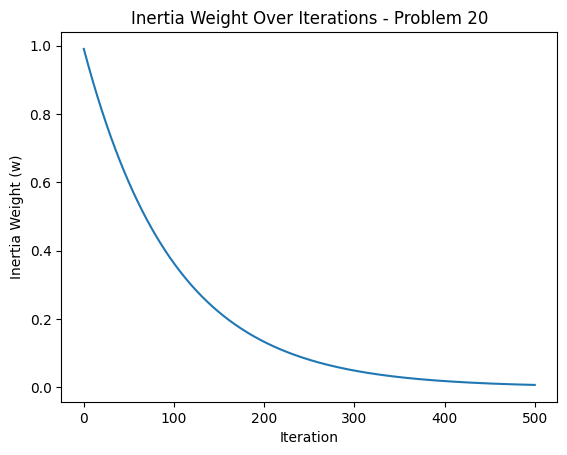

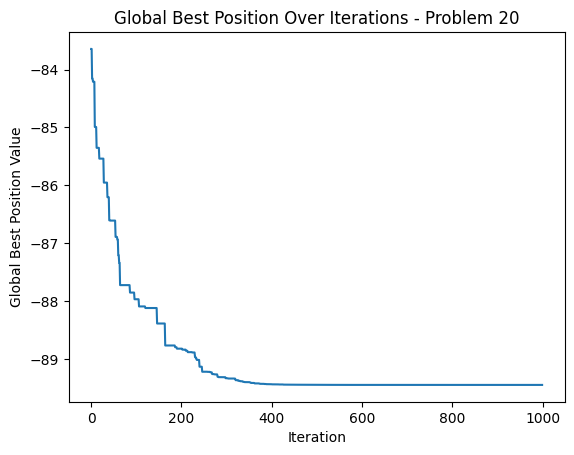




Problem 21 Best Cost: [-40.81931978 -42.560676   -42.95787328 -42.95787328 -42.95787328
 -42.95787328 -42.95787328 -42.95787328 -42.95787328 -42.95787328
 -42.95787328 -42.95787328 -42.95787328 -42.95787328 -42.95787328
 -42.99614369 -42.99614369 -42.99614369 -42.99614369 -42.99614369
 -42.99614369 -42.99614369 -42.99614369 -42.99614369 -42.99614369
 -42.99614369 -42.99614369 -42.99614369 -42.99614369 -42.99614369
 -42.99614369 -42.99614369 -43.02422448 -43.02422448 -43.02422448
 -43.02422448 -43.02422448 -43.02422448 -43.04686078 -43.04686078
 -43.04686078 -43.04686078 -43.04686078 -43.28101863 -43.39650284
 -43.59134565 -43.61425071 -43.66386518 -43.66386518 -43.66386518
 -43.69400078 -43.69400078 -43.69400078 -43.80324893 -43.80324893
 -43.80324893 -43.80324893 -43.80324893 -43.80324893 -43.80324893
 -43.80324893 -43.82755242 -43.82755242 -43.82755242 -43.83110369
 -43.83110369 -43.83110369 -43.840454   -43.840454   -43.85461082
 -43.85461082 -43.86095605 -43.86095605 -43.8609560

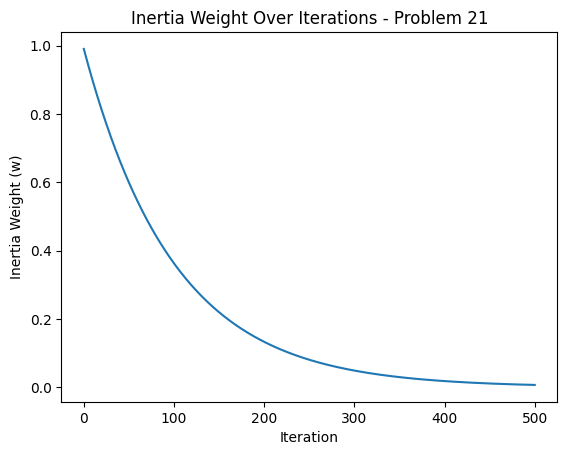

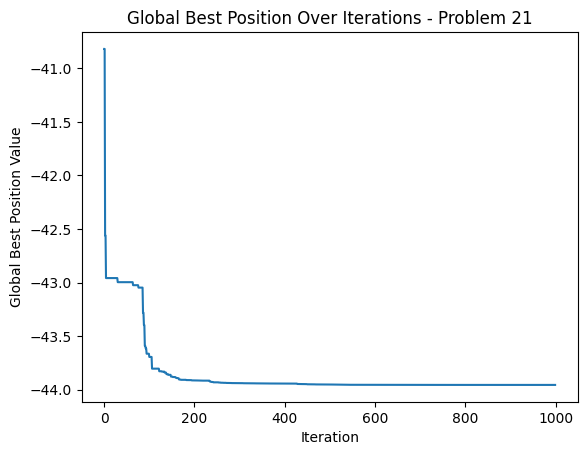




Problem 22 Best Cost: [246349.48758527 246349.48758527 213254.16198228 213254.16198228
 176837.65882586 173291.37104442 173291.37104442 173291.37104442
 173291.37104442 173291.37104442 173291.37104442 173291.37104442
 173291.37104442 173291.37104442 173291.37104442 173291.37104442
 160095.75525912 160095.75525912 160095.75525912 158325.20785794
 158325.20785794 149821.01518797 141313.34213228 136964.30858688
 127300.9133925  127300.9133925  127300.9133925  127300.9133925
 127300.9133925  127300.9133925  127300.9133925  127300.9133925
 127300.9133925  127300.9133925  127300.9133925  127300.9133925
 127300.9133925  122389.33261971 122389.33261971 112132.05567743
 112132.05567743 112132.05567743 112132.05567743 112132.05567743
 112132.05567743 112132.05567743 112132.05567743 112132.05567743
 112132.05567743 112132.05567743 112132.05567743 112132.05567743
 112132.05567743 112132.05567743 112132.05567743 112132.05567743
 112132.05567743 112132.05567743 112132.05567743 112132.05567743
 11

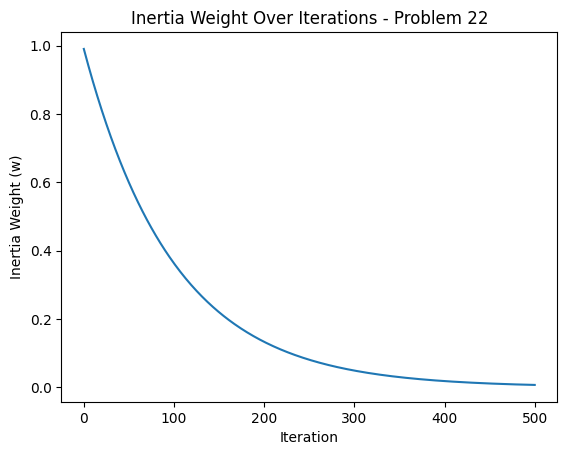

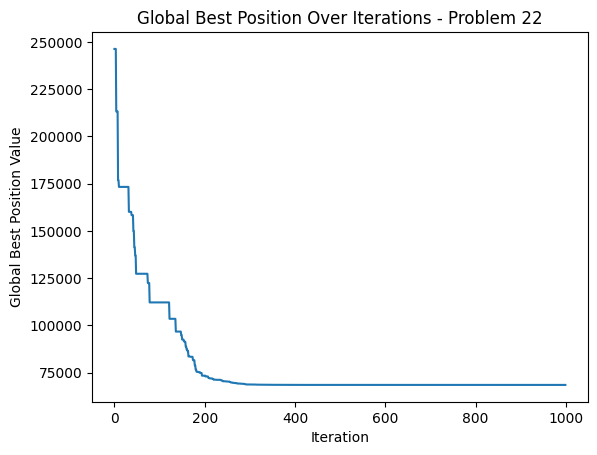




Problem 23 Best Cost: [-27.21308703 -27.2618641  -27.2618641  -27.2618641  -28.02812681
 -28.02812681 -28.02812681 -28.02812681 -33.56526449 -33.56526449
 -33.56526449 -41.78745207 -41.78745207 -41.78745207 -41.78745207
 -41.78745207 -41.78745207 -43.32735786 -43.32735786 -43.32735786
 -43.32735786 -43.32735786 -43.32735786 -43.32735786 -43.32735786
 -43.32735786 -43.32735786 -43.32735786 -43.32735786 -43.32735786
 -43.32735786 -43.32735786 -43.32735786 -43.32735786 -43.32735786
 -43.32735786 -47.42349071 -47.42349071 -47.42349071 -47.42349071
 -47.42349071 -47.42349071 -47.42349071 -47.42349071 -47.42349071
 -47.42349071 -47.42349071 -48.16305142 -48.16305142 -48.16305142
 -48.16305142 -48.16305142 -48.23645216 -49.23909019 -49.23909019
 -49.23909019 -49.23909019 -49.23909019 -50.57202005 -50.57202005
 -50.57202005 -50.57202005 -50.57202005 -50.57202005 -50.57202005
 -50.57202005 -50.57202005 -50.57202005 -50.57202005 -50.57202005
 -50.57202005 -52.31139109 -52.31139109 -52.3113910

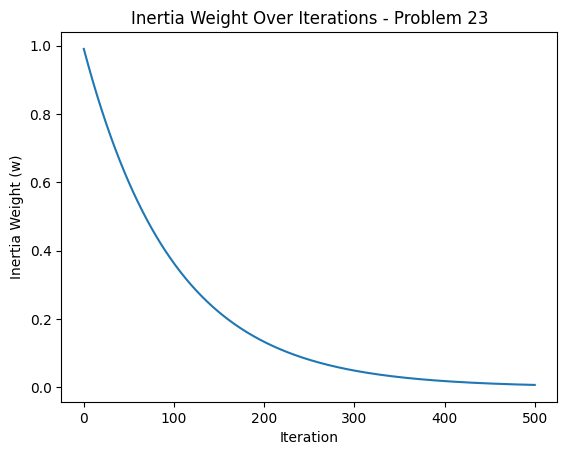

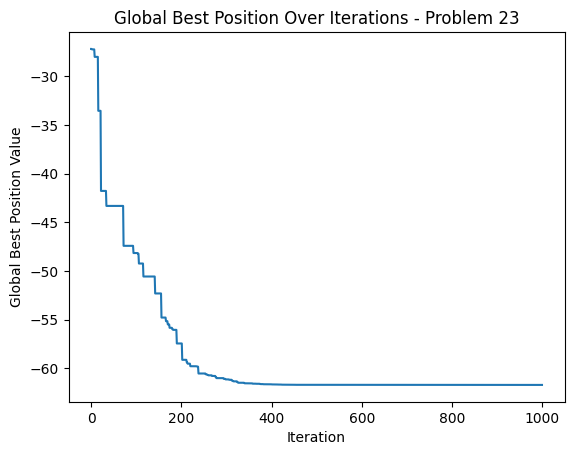




Problem 24 Best Cost: [110.44436878  93.36657309  93.36657309  93.36657309  93.36657309
  91.38273682  91.38273682  91.38273682  91.31781142  85.13066458
  85.13066458  85.13066458  85.13066458  85.13066458  85.13066458
  85.13066458  85.13066458  85.13066458  84.08236026  79.18297861
  79.18297861  78.56875575  78.56875575  78.56875575  78.56875575
  78.56875575  75.57695284  75.57695284  75.57695284  75.57695284
  75.57695284  71.28525448  71.28525448  71.28525448  71.28525448
  71.28525448  68.868836    66.11939661  66.11939661  66.11939661
  66.11939661  66.11939661  66.11939661  66.11939661  66.11939661
  66.11939661  66.11939661  66.11939661  66.11939661  66.11939661
  66.11939661  66.11939661  66.11939661  66.11939661  66.11939661
  66.11939661  66.11939661  66.11939661  62.77686669  62.77686669
  62.77686669  62.77686669  61.84316088  61.84316088  61.84316088
  61.84316088  61.84316088  61.84316088  61.84316088  61.84316088
  61.84316088  61.84316088  61.06489412  61.0648941

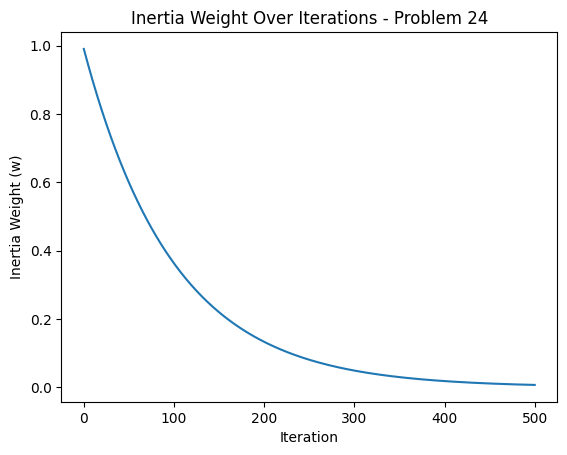

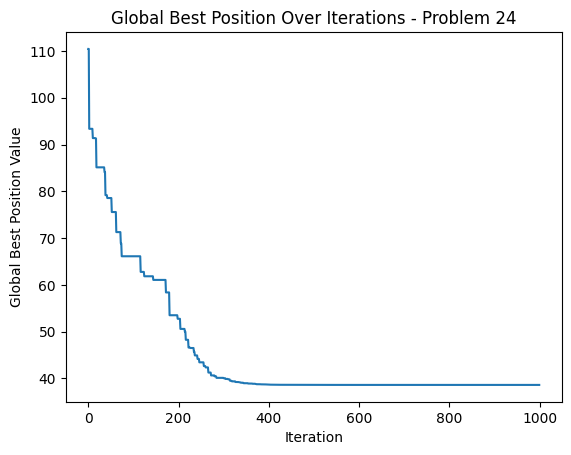

In [13]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()